# Explorando os dados

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from yellowbrick.features import (
    JointPlotVisualizer,
    Rank2D,
    RadViz,
    ParallelCoordinates)
from sklearn.experimental import (
    enable_iterative_imputer,
)
from sklearn import (
    ensemble,
    impute,
    model_selection,    
    preprocessing,
    tree,
)

In [19]:
url = ("https://hbiostat.org/data/repo/titanic3.csv")
df = pd.read_csv(url)
org_df = df

In [20]:
def tweak_titanic(df):
    df = df.drop(
        columns=[
            "name",
            "ticket",
            "home.dest",
            "boat",
            "body",
            "cabin",
        ]
    ).pipe(pd.get_dummies, drop_first=True)
    return df

def get_train_test_X_y(
    df, y_col, size=0.3, std_cols=None
):
    y = df[y_col]
    X = df.drop(columns=y_col)
    X_train, X_test, y_train, y_test = model_selection.train_test_split(
        X, y, test_size=size, random_state=42
    )
    cols = X.columns
    num_cols = [
        "pclass",
        "age",
        "sibsp",
        "parch",
        "fare",
    ]
    fi = impute.IterativeImputer()
    fitted = fi.fit_transform(X_train[num_cols])
    X_train = X_train.assign(**{c:fitted[:,i] for i, c in enumerate(num_cols)})
    test_fit = fi.transform(X_test[num_cols])
    X_test = X_test.assign(**{c:test_fit[:,i] for i, c in enumerate(num_cols)})
    if std_cols:
        std = preprocessing.StandardScaler()
        fitted = std.fit_transform(X_train[std_cols])
        X_train = X_train.assign(**{c:fitted[:,i] for i, c in enumerate(std_cols)})
        test_fit = std.transform(X_test[std_cols])
        X_test = X_test.assign(**{c:test_fit[:,i] for i, c in enumerate(std_cols)})

    return X_train, X_test, y_train, y_test

ti_df = tweak_titanic(org_df)
std_cols = "pclass,age,sibsp,fare".split(",")
X_train, X_test, y_train, y_test = get_train_test_X_y(
    ti_df, "survived", std_cols=std_cols
)

X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])


## Tamanho dos dados

O tamanho dos dados pode ser obtido de diversas formas. A mais simples é através da propriedade `shape` do `DataFrame`.

In [28]:
X.shape

(1309, 8)

1309 linhas e 8 colunas.

Uma forma alternativa seria através do método `info()`.

Este metodo retorna o tamanho dos dados e também o tipo de cada coluna.

In [29]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1309 entries, 1214 to 513
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   pclass      1309 non-null   float64
 1   age         1309 non-null   float64
 2   sibsp       1309 non-null   float64
 3   parch       1309 non-null   float64
 4   fare        1309 non-null   float64
 5   sex_male    1309 non-null   bool   
 6   embarked_Q  1309 non-null   bool   
 7   embarked_S  1309 non-null   bool   
dtypes: bool(3), float64(5)
memory usage: 65.2 KB


Utilizando o método `describe()` é possível obter algumas estatísticas descritivas dos dados.

- `count`: quantidade de valores válidos - não nulos

- `mean`: média dos valores

- `std`: desvio padrão

- `min`: valor mínimo

- `25%`: primeiro quartil

- `50%`: segundo quartil ou mediana

- `75%`: terceiro quartil

- `max`: valor máximo

In [30]:
X.describe()

,pclass,age,sibsp,parch,fare
count,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000
mean,-0.012831,0.052084,-0.037396,0.385027,-0.007599
std,0.995822,1.038466,0.963074,0.865560,0.980143
min,-1.551881,-2.220991,-0.498616,0.000000,-0.704308
25%,-0.363317,-0.517409,-0.498616,0.000000,-0.488146
50%,0.825248,-0.166237,-0.498616,0.000000,-0.363928
75%,0.825248,0.575131,0.425943,0.000000,-0.045335
max,0.825248,4.008828,6.897852,9.000000,9.066014


Utilizando o atributo `iloc` é possível acessar os dados de uma linha específica. Juntando ele ao `describe()` é possível obter as estatísticas descritivas de uma linha específica. Neste caso, busca-se a primeira e a última linha

Com este atributo é possível selecionar linhas e colunas específicas com base na posição de um índice. Para o `iloc` o índice é numérico.

O atributo `loc` é similar ao `iloc`, porém o índice é o valor do índice e não a posição. No caso dos DataFrames, o índice é nome da posição.

In [31]:
X.describe().iloc[:, [0,-1]]

,pclass,fare
count,1309.000000,1309.000000
mean,-0.012831,-0.007599
std,0.995822,0.980143
min,-1.551881,-0.704308
25%,-0.363317,-0.488146
50%,0.825248,-0.363928
75%,0.825248,-0.045335
max,0.825248,9.066014


## Histogramas

Histogramas são gráficos que permitem visualizar a distribuição dos dados. São bem simples de serem gerados, basta utilizar `.plot(kind='hist')` no DataFrame, utilizando o `matplotlib` como backend.

Os valores devem ser numéricos para que o histograma seja gerado.

<Axes: ylabel='Frequency'>

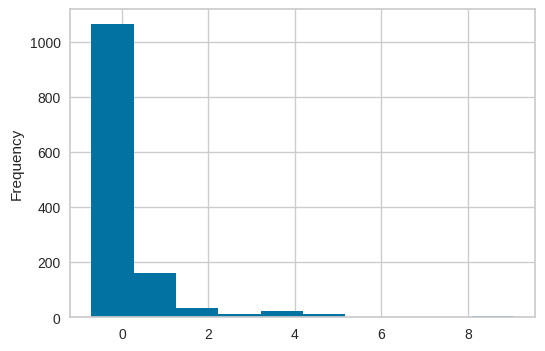

In [32]:
fig, ax = plt.subplots(figsize=(6,4))

X.fare.plot(kind='hist', ax=ax)

Utlizando `seaborn` é possível gerar histogramas com mais facilidade. Basta utilizar `sns.distplot()`. Este método já gera o histograma e também a curva de densidade.

/tmp/ipykernel_22686/1183253325.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(X_train[mask].fare, label="Survived")
/tmp/ipykernel_22686/1183253325.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(X_train[~mask].fare, label="Died")


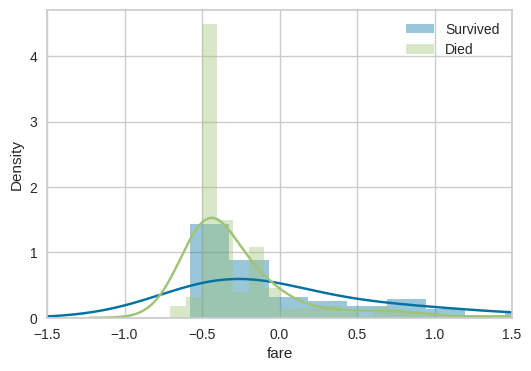

In [38]:
fig, ax = plt.subplots(figsize=(6,4))
mask = y_train == 1

ax = sns.distplot(X_train[mask].fare, label="Survived")
ax = sns.distplot(X_train[~mask].fare, label="Died")

ax.set_xlim(-1.5, 1.5)
ax.legend()

## Scatterplots

Scatterplots são gráficos que permitem visualizar a relação entre duas variáveis. São bem simples de serem gerados, basta utilizar `.plot.scatter(x='coluna1', y='coluna2')` no DataFrame, utilizando o `matplotlib` como backend.

Ajuste os valores de `c` e `colormap` para obter um gráfico mais informativo.

O paràmetro `alpha` ajusta a transparência dos pontos.

Além disso os Scatterplots são extremamente úteis para identificar outliers.

<Axes: xlabel='age', ylabel='fare'>

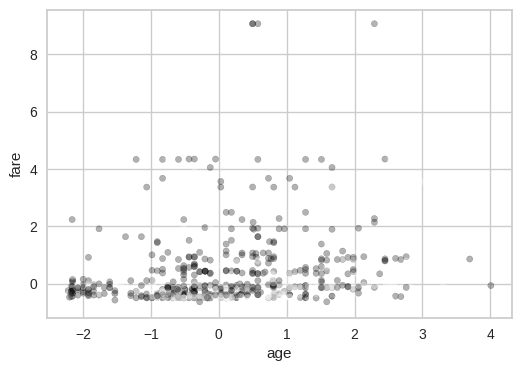

In [43]:
fig, ax = plt.subplots(figsize=(6,4))

X.plot.scatter(
    x="age", y="fare",c=y, ax=ax, alpha=0.3 # Ajuste o alpha se houver sobreposição de pontos
)


Não aparenta haver uma relação entre as variáveis, poia os pontos estão bem espalhados.

É possível utilizar a correlação de Pearson para verificar se há uma relação entre as variáveis. Para isso, basta utilizar o método `corr()` do DataFrame.  O valor retornado varia entre -1 e 1. Quanto mais próximo de 1, maior a correlação positiva. Quanto mais próximo de -1, maior a correlação negativa. Quanto mais próximo de 0, menor a correlação.

In [44]:
X.age.corr(X.fare)

0.17720039845406121

## Gráfico Conjunto (Jointplot)

É um gráfico de dispersão com histogramas nas margens. Utlizando `JointPlotVisualization` do `yellowbrick` é possível gerar este gráfico.
Combinando essa biblioteca com o `seaborn` é possível gerar uma reta de regressão através do metodo `regplot()`.

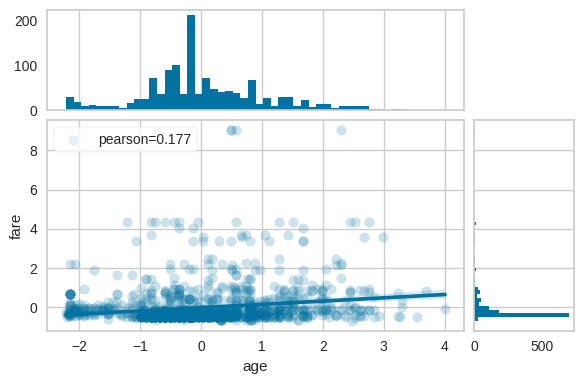

<Axes: xlabel='age', ylabel='fare'>

In [52]:
fig, ax = plt.subplots(figsize=(6,4))
jpv = JointPlotVisualizer(
    feature="age", target="fare",kind="scatter", alpha=0.1
)
jpv.fit(X.age, X.fare)

sns.regplot(x=X.age, y=X.fare, ax=ax, scatter_kws={"alpha": 0.1})
jpv.show()


É possível gerar o mesmo gráfico utilizando apenas o `seaborn` com o método `jointplot()`.

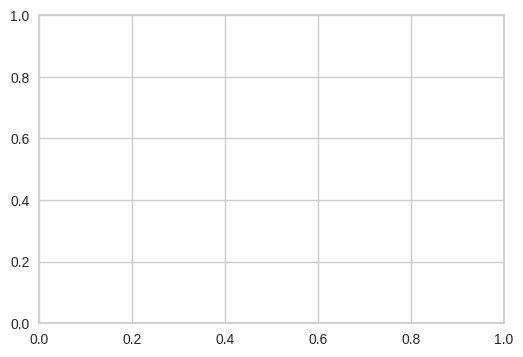

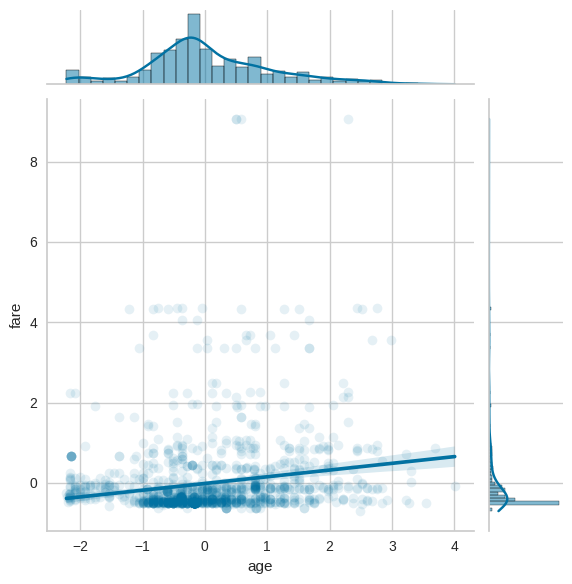

In [53]:
fig, ax = plt.subplots(figsize=(6,4))
new_df = X.copy()
new_df["survived"] = y

p = sns.jointplot(
    x="age", y="fare", data=new_df, kind="reg", scatter_kws={"alpha": 0.1}
)
